In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from make_figure_functions import inter_number
from make_figure_functions import get_inters
from make_figure_functions import inter_mix_number
from matplotlib.patches import Wedge
import matplotlib as mpl
import math
import os

import anndata
import scanpy as sc

print('Load high-quality cells only')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = sc.read_h5ad(fn_h5ad)
print('Normalize data to CPM')
sc.pp.normalize_total(adata, target_sum=1e6)

adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']
from adata_utilis import split_adata
adata_dic = split_adata(adata)

Load high-quality cells only
Normalize data to CPM


/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [206]:
log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/log2_fc_ave_kids.tsv', index_col=['cell_type', 'gene'])
log2_fc =pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/log2_fc_ave_kids.tsv', index_col=['gene','cell_type', ])

genes = log2_fc_ave.loc['B_cells'].index.tolist()
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
same_trend = {}
same_trend['up'] = defaultdict(list)
same_trend['down'] = defaultdict(list)
for gene in genes:
    if (log2_fc.loc[gene]['fold_2_change'] >= 0.8).sum() >= 4:
        ct_ls = log2_fc.loc[gene][log2_fc.loc[gene]['fold_2_change'] >= 1].index.tolist()
        for ct in ct_ls:
            same_trend['up'][ct].append(gene)
    elif (log2_fc.loc[gene]['fold_2_change'] <= -0.8).sum() >= 4:
        ct_ls = log2_fc.loc[gene][log2_fc.loc[gene]['fold_2_change'] <= -1].index.tolist()
        for ct in ct_ls:
            same_trend['down'][ct].append(gene)
            
#up & up
up_up = get_inters(same_trend['up'], same_trend['up'])
up_up = up_up[~up_up[['ga', 'gb']].duplicated()] ###to get the inters and don't care too much about cell types

#down & down
down_down = get_inters(same_trend['down'], same_trend['down'])
down_down = down_down[~down_down[['ga', 'gb']].duplicated()] ###to get the inters and don't care too much about cell types

# up & down
up_down = get_inters(same_trend['up'], same_trend['down'])
up_down = up_down[~up_down[['ga', 'gb']].duplicated()] ###to get the inters and don't care too much about cell types

Load interaction
Get interactions
Load interaction
Get interactions
Load interaction
Get interactions


In [207]:
ga_uu = up_up['ga'].tolist()[::2]
gb_uu = up_up['gb'].tolist()[::2]
up_up

,cta,ctb,ga,gb


In [208]:
ga_dd = down_down['ga'].tolist()[::2]
gb_dd = down_down['gb'].tolist()[::2]
down_down

,cta,ctb,ga,gb
0,Monocytes,cDCs,HLA-G,LILRB2
4,cDCs,Monocytes,LILRB2,HLA-G


In [209]:
ga_ud = up_down['ga'].tolist()
gb_ud = up_down['gb'].tolist()
up_down

,cta,ctb,ga,gb
1,Monocytes,NK_cells,ITGA1,COL18A1


In [219]:
################################## Define up, down, normal cell_types by log2_FC & com_frac & exp_frac

up_cd = (log2_fc_ave['fold_2_change'] >= 1) & (log2_fc_ave['comp_frac'] > 0.5) & (log2_fc_ave['SD_exp_frac'] >= 0.02)
#up_cd = (log2_fc_ave['fold_2_change'] >= 1) & (np.log10(log2_fc_ave['p_value']) <= -3) & (log2_fc_ave['SD_exp_frac'] >= 0.05)
up_df = log2_fc_ave[up_cd]
#up_df.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/up_genes.tsv')
print('Number of up genes is %s' % up_df.shape[0])
up_cts = list(set([idx[0] for idx in up_df.index.tolist()]))
print('Cell types for up genes are %s' % up_cts)

down_cd = (log2_fc_ave['fold_2_change'] <= -1) & (log2_fc_ave['comp_frac'] < 0.5) & (log2_fc_ave['D_exp_frac'] >= 0.02)
#down_cd = (log2_fc_ave['fold_2_change'] <= -1) & (-np.log10(log2_fc_ave['p_value']) >= 3) & (log2_fc_ave['D_exp_frac'] >= 0.05)
down_df = log2_fc_ave[down_cd]
#down_df.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/down_genes.tsv')
print('Number of down genes is %s' % down_df.shape[0])
down_cts = list(set([idx[0] for idx in down_df.index.tolist()]))
print('Cell types for down genes are %s' % down_cts)

normal_df = log2_fc_ave[~ (up_cd | down_cd)]
#normal_df.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/normal_genes.tsv')
print('Number of normal genes is %s' % normal_df.shape[0])
normal_cts = list(set([idx[0] for idx in normal_df.index.tolist()]))
print('Cell types for normal genes are %s' % normal_cts)

up_genes = {ct: up_df.loc[ct].index.tolist() for ct in up_cts}
down_genes = {ct: down_df.loc[ct].index.tolist() for ct in down_cts}
normal_genes = {ct: normal_df.loc[ct].index.tolist() for ct in normal_cts}

print('Get genes at each condition')

up_up_inters = get_inters(up_genes, up_genes)
#inter_number(up_up_inters, 15, 'up')
down_down_inters = get_inters(down_genes, down_genes)
#inter_number(down_down_inters, 20, 'down')
up_down_inters = get_inters(up_genes, down_genes)
#inter_mix_number(up_down_inters, 15)

######################################
def get_inter_info(up_im_all, up_up_inters):
    up_all_info = {idx: [cta, ctb, ga, gb]for idx, cta, ctb, ga, gb in zip(up_im_all.index.tolist(), up_im_all['cta'].tolist(), up_im_all['ctb'].tolist(), up_im_all['ga'].tolist(), up_im_all['gb'].tolist())}
    up_info = [[cta, ctb, ga, gb] for cta, ctb, ga, gb in zip(up_up_inters['cta'].tolist(), up_up_inters['ctb'].tolist(), up_up_inters['ga'].tolist(), up_up_inters['gb'].tolist())]

    up_up = pd.DataFrame([], columns = up_im_all.columns)
    for info in up_info:
        if info in up_all_info.values():
            idx = list(up_all_info.keys())[list(up_all_info.values()).index(info)]
            up_up.loc[idx] = up_im_all.loc[idx]

    return up_up
######################################
inters_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_im_all_002ave_new.tsv', index_col=0)
up_im_all = inters_im_all[inters_im_all['up/down'] == 'up']
down_im_all = inters_im_all[inters_im_all['up/down'] == 'down']

mix_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_mix_all_002ave_new.tsv', index_col=0)

up_up = get_inter_info(up_im_all, up_up_inters)
up_up.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/up_up.tsv')

down_down = get_inter_info(down_im_all, down_down_inters)
down_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/down_down.tsv')

up_down = get_inter_info(mix_im_all, up_down_inters)
up_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/up_down.tsv')

Number of up genes is 119
Cell types for up genes are ['T_cells', 'pDCs', 'NK_cells', 'cDCs', 'Monocytes', 'Plasmablasts']
Number of down genes is 230
Cell types for down genes are ['T_cells', 'B_cells', 'pDCs', 'NK_cells', 'cDCs', 'Monocytes', 'Plasmablasts']
Number of normal genes is 6259
Cell types for normal genes are ['T_cells', 'B_cells', 'pDCs', 'NK_cells', 'cDCs', 'Monocytes', 'Plasmablasts']
Get genes at each condition
Load interaction
Get interactions
Load interaction
Get interactions
Load interaction
Get interactions


In [29]:
up_up = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/up_up.tsv', index_col=0)

down_down= pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/down_down.tsv', index_col=0)

up_down= pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/up_down.tsv', index_col=0)

In [30]:
a = up_up
#[(up_up['ga_SD_exp_frac'] >= 0.03) & (up_up['gb_SD_exp_frac'] >= 0.03)]
#a = up_up[(up_up['ga_comfrac'] > 0.7) & (up_up['gb_comfrac'] > 0.7)]
a

,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac,up/down
299,GAS6,AXL,Monocytes,cDCs,1.067188,0.750000,0.019808,0.079193,1.678198,0.583333,0.055468,0.115141,up
409,GAS6,AXL,Plasmablasts,cDCs,2.028105,0.968750,0.045075,0.200937,1.678198,0.583333,0.055468,0.115141,up
1470,ENTPD1,ADORA2A,NK_cells,Plasmablasts,2.187141,1.000000,0.004358,0.021604,1.720058,0.812500,0.014702,0.037390,up
1626,ADORA2A,ENTPD1,Plasmablasts,T_cells,1.720058,0.812500,0.014702,0.037390,1.505202,0.750000,0.013258,0.048717,up
410,ADORA2A,ENTPD1,Plasmablasts,cDCs,1.720058,0.812500,0.014702,0.037390,1.512843,0.833333,0.066580,0.176901,up
5,TNF,VSIR,cDCs,pDCs,2.782097,0.791667,0.055452,0.141198,1.419964,0.875000,0.129678,0.274376,up
6,EFNB1,EPHB1,cDCs,pDCs,2.966182,0.541667,0.032609,0.077647,1.558152,0.625000,0.131195,0.226335,up
414,RIPK1,TNF,Plasmablasts,cDCs,1.097191,0.687500,0.037454,0.059534,2.782097,0.791667,0.055452,0.141198,up
15,TNFRSF25,TNFSF12,cDCs,pDCs,3.335692,0.625000,0.005435,0.042976,2.472095,0.562500,0.004902,0.039518,up
1713,CTLA4,CD86,T_cells,pDCs,1.346137,0.687500,0.030141,0.084372,1.310030,0.531250,0.033748,0.048455,up


In [5]:
b = down_down[:30]
#[(down_down['ga_D_exp_frac'] >= 0.03) & (down_down['gb_D_exp_frac'] >= 0.03)]
#b[(b['ga_comfrac'] <= 0.4) & (b['gb_comfrac'] <=0.4)]
b

,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac,up/down
527,MDK,LRP1,Monocytes,cDCs,-1.126591,0.218750,0.021895,0.098142,-2.657081,0.250000,0.126691,0.075300,down
658,MDK,LRP1,Plasmablasts,cDCs,-1.566653,0.187500,0.027398,0.098142,-2.657081,0.250000,0.126691,0.075300,down
533,TNFSF12,TNFRSF12A,Monocytes,cDCs,-1.114051,0.375000,0.049658,0.020833,-2.259473,0.125000,0.038647,0.027778,down
58,NRP1,VEGFB,cDCs,pDCs,-1.294905,0.250000,0.022101,0.014122,-3.126767,0.156250,0.231432,0.055852,down
59,FAS,FASLG,cDCs,pDCs,-2.476596,0.166667,0.155485,0.084176,-1.941291,0.000000,0.025000,0.055852,down
64,PTGIR,GHRL,cDCs,pDCs,-3.341962,0.250000,0.071998,0.031212,-1.732356,0.187500,0.033748,0.055852,down
2267,PTGIR,GHRL,Monocytes,pDCs,-1.201857,0.312500,0.039474,0.017459,-1.732356,0.187500,0.033748,0.055852,down
542,NOTCH2,JAG1,Monocytes,cDCs,-1.545120,0.281250,0.171261,0.001225,-1.246185,0.125000,0.027778,0.001634,down
543,CD226,NECTIN2,Monocytes,cDCs,-1.865472,0.187500,0.027245,0.056669,-2.709225,0.208333,0.078053,0.020004,down
2270,CD72,SEMA4D,Monocytes,pDCs,-1.047501,0.250000,0.025969,0.066851,-2.295203,0.250000,0.068135,0.055852,down


In [225]:
c = up_down[:45]
#[(up_down['ga_SD_exp_frac'] >= 0.05) & (up_down['gb_D_exp_frac'] >= 0.05)]
#c[(c['ga_comfrac'] <= 0.4) & (c['gb_comfrac'] <=0.4)]
c

,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac
381,CXCR3,CCL19,Plasmablasts,cDCs,1.753582,0.843750,0.167706,0.428756,-6.031390,0.000000,0.039406,0.000000
861,ADORA2A,NAMPT,Plasmablasts,pDCs,1.720058,0.812500,0.014702,0.037390,-1.004081,0.468750,0.186008,0.233961
1,EFNB1,EPHB2,cDCs,Monocytes,2.966182,0.541667,0.032609,0.077647,-1.356263,0.375000,0.043643,0.046965
899,VEGFA,EPHB2,Plasmablasts,Monocytes,2.430389,0.937500,0.005456,0.024363,-1.356263,0.375000,0.043643,0.046965
25,TNF,NOTCH1,cDCs,pDCs,2.782097,0.791667,0.055452,0.141198,-2.115351,0.250000,0.040845,0.022847
402,TNFSF12,TNFRSF12A,pDCs,cDCs,2.472095,0.562500,0.004902,0.039518,-2.259473,0.125000,0.038647,0.027778
44,CXCL2,CXCR1,cDCs,NK_cells,3.390164,0.666667,0.005435,0.048287,-1.760573,0.156250,0.036383,0.024760
768,EFNB1,EPHB1,cDCs,cDCs,2.966182,0.541667,0.032609,0.077647,-2.151719,0.125000,0.022101,0.008170
52,TNF,TNFRSF1A,cDCs,pDCs,2.782097,0.791667,0.055452,0.141198,-1.341552,0.437500,0.191589,0.153198
770,TNF,TNFRSF1A,cDCs,cDCs,2.782097,0.791667,0.055452,0.141198,-1.647370,0.333333,0.165872,0.189996


In [134]:
ZY_genes = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/all_deg_febe_list_Zhiyuan.tsv', sep='\t', index_col=['celltype', 'gene_name'])
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
ZY_up_genes = {ct:ZY_genes.loc[ct][ZY_genes.loc[ct]['log2_fold_change'] > 0].index.tolist() for ct in cell_types}
ZY_down_genes = {ct:ZY_genes.loc[ct][ZY_genes.loc[ct]['log2_fold_change'] < 0].index.tolist() for ct in cell_types}
######################################
ZY_up_up_inters = get_inters(ZY_up_genes, ZY_up_genes)
#inter_number(up_up_inters, 15, 'up')
ZY_down_down_inters = get_inters(ZY_down_genes, ZY_down_genes)
#inter_number(down_down_inters, 20, 'down')
ZY_up_down_inters = get_inters(ZY_up_genes, ZY_down_genes)
#inter_mix_number(up_down_inters, 15)

######################################
def get_inter_info(up_im_all, up_up_inters):
    up_all_info = {idx: [cta, ctb, ga, gb]for idx, cta, ctb, ga, gb in zip(up_im_all.index.tolist(), up_im_all['cta'].tolist(), up_im_all['ctb'].tolist(), up_im_all['ga'].tolist(), up_im_all['gb'].tolist())}
    up_info = [[cta, ctb, ga, gb] for cta, ctb, ga, gb in zip(up_up_inters['cta'].tolist(), up_up_inters['ctb'].tolist(), up_up_inters['ga'].tolist(), up_up_inters['gb'].tolist())]

    up_up = pd.DataFrame([], columns = up_im_all.columns)
    for info in up_info:
        if info in up_all_info.values():
            idx = list(up_all_info.keys())[list(up_all_info.values()).index(info)]
            up_up.loc[idx] = up_im_all.loc[idx]

    return up_up
######################################
inters_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_im_all_002ave_new.tsv', index_col=0)
up_im_all = inters_im_all[inters_im_all['up/down'] == 'up']
down_im_all = inters_im_all[inters_im_all['up/down'] == 'down']

mix_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_mix_all_002ave_new.tsv', index_col=0)

ZY_up_up = get_inter_info(up_im_all, ZY_up_up_inters)
ZY_up_up.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/ZY_up_up.tsv')

ZY_down_down = get_inter_info(down_im_all, ZY_down_down_inters)
ZY_down_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/ZY_down_down.tsv')

ZY_up_down = get_inter_info(mix_im_all, ZY_up_down_inters)
ZY_up_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/ZY_up_down.tsv')

Load interaction
Get interactions
Load interaction
Get interactions
Load interaction
Get interactions


In [145]:
ZY_genes.loc['NK_cells', 'ICAM2']

Unnamed: 0          7.700000e+01
statistic           1.350956e-01
pvalue              5.773160e-15
avg1                3.754447e+00
avg2                2.652412e+00
log2_fold_change   -1.102035e+00
Name: (NK_cells, ICAM2), dtype: float64

In [137]:
ZY_up_down

,ga,gb,cta,ctb,ga_log2FC,ga_comfrac,ga_D_exp_frac,ga_SD_exp_frac,gb_log2FC,gb_comfrac,gb_D_exp_frac,gb_SD_exp_frac
1224,ALOX5,ALOX5AP,Monocytes,NK_cells,0.543037,0.75000,0.185273,0.329838,-0.816578,0.03125,0.628284,0.461825
1230,CXCR3,CXCL10,Plasmablasts,Monocytes,1.753582,0.84375,0.167706,0.428756,-2.538432,0.21875,0.299682,0.080049
2160,ITGB2,FCER2,Monocytes,B_cells,0.401199,0.81250,0.710728,0.825442,-0.645218,0.06250,0.410183,0.320061
2163,ITGB2,FCER2,T_cells,B_cells,0.213589,0.62500,0.472063,0.566749,-0.645218,0.06250,0.410183,0.320061
2183,ITGB2,ICAM2,Monocytes,NK_cells,0.401199,0.81250,0.710728,0.825442,-0.675492,0.03125,0.387631,0.301646
2192,ITGB2,ICAM2,T_cells,NK_cells,0.213589,0.62500,0.472063,0.566749,-0.675492,0.03125,0.387631,0.301646
2229,ITGAM,FCER2,Monocytes,B_cells,0.860385,0.84375,0.103941,0.260186,-0.645218,0.06250,0.410183,0.320061


In [198]:
################################## Define up, down, normal cell_types by com_frac & exp_frac
log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/log2_fc_ave_kids.tsv', index_col=['cell_type', 'gene'])

up_cd = (log2_fc_ave['fold_2_change'] >= 0.8) & (log2_fc_ave['comp_frac'] > 0.875) & (log2_fc_ave['SD_exp_frac'] >= 0.02)
up_df = log2_fc_ave[up_cd]
print('Number of up genes is %s' % up_df.shape[0])
up_cts = list(set([idx[0] for idx in up_df.index.tolist()]))
print('Cell types for up genes are %s' % up_cts)

down_cd = (log2_fc_ave['fold_2_change'] <= -0.8) & (log2_fc_ave['comp_frac'] < 0.25) & (log2_fc_ave['D_exp_frac'] >= 0.02)
down_df = log2_fc_ave[down_cd]
print('Number of down genes is %s' % down_df.shape[0])
down_cts = list(set([idx[0] for idx in down_df.index.tolist()]))
print('Cell types for down genes are %s' % down_cts)

normal_df = log2_fc_ave[~ (up_cd | down_cd)]
print('Number of normal genes is %s' % normal_df.shape[0])
normal_cts = list(set([idx[0] for idx in normal_df.index.tolist()]))
print('Cell types for normal genes are %s' % normal_cts)

up_genes = {ct: up_df.loc[ct].index.tolist() for ct in up_cts}
down_genes = {ct: down_df.loc[ct].index.tolist() for ct in down_cts}
normal_genes = {ct: normal_df.loc[ct].index.tolist() for ct in normal_cts}

print('Get genes at each condition')

up_up_inters = get_inters(up_genes, up_genes)
#inter_number(up_up_inters, 15, 'up')
down_down_inters = get_inters(down_genes, down_genes)
#inter_number(down_down_inters, 20, 'down')
up_down_inters = get_inters(up_genes, down_genes)
#inter_mix_number(up_down_inters, 15)

######################################
def get_inter_info(up_im_all, up_up_inters):
    up_all_info = {idx: [cta, ctb, ga, gb]for idx, cta, ctb, ga, gb in zip(up_im_all.index.tolist(), up_im_all['cta'].tolist(), up_im_all['ctb'].tolist(), up_im_all['ga'].tolist(), up_im_all['gb'].tolist())}
    up_info = [[cta, ctb, ga, gb] for cta, ctb, ga, gb in zip(up_up_inters['cta'].tolist(), up_up_inters['ctb'].tolist(), up_up_inters['ga'].tolist(), up_up_inters['gb'].tolist())]

    up_up = pd.DataFrame([], columns = up_im_all.columns)
    for info in up_info:
        if info in up_all_info.values():
            idx = list(up_all_info.keys())[list(up_all_info.values()).index(info)]
            up_up.loc[idx] = up_im_all.loc[idx]

    return up_up
######################################
inters_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_im_all_002ave_new.tsv', index_col=0)
up_im_all = inters_im_all[inters_im_all['up/down'] == 'up']
down_im_all = inters_im_all[inters_im_all['up/down'] == 'down']

mix_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inters_mix_all_002ave_new.tsv', index_col=0)

up_up = get_inter_info(up_im_all, up_up_inters)
#up_up.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/up_up.tsv')

down_down = get_inter_info(down_im_all, down_down_inters)
#down_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/down_down.tsv')

up_down = get_inter_info(mix_im_all, up_down_inters)
#up_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/up_down.tsv')

Number of up genes is 32
Cell types for up genes are ['T_cells', 'B_cells', 'pDCs', 'NK_cells', 'cDCs', 'Monocytes', 'Plasmablasts']
Number of down genes is 147
Cell types for down genes are ['T_cells', 'B_cells', 'pDCs', 'NK_cells', 'cDCs', 'Monocytes', 'Plasmablasts']
Number of normal genes is 6429
Cell types for normal genes are ['T_cells', 'B_cells', 'pDCs', 'NK_cells', 'cDCs', 'Monocytes', 'Plasmablasts']
Get genes at each condition
Load interaction
Get interactions
Load interaction
Get interactions
Load interaction
Get interactions


In [164]:
def mushrooms(genes):
    from matplotlib.patches import Wedge
    import matplotlib as mpl
    import math
    cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    conditions = ['S_dengue', 'dengue']
    cmap = plt.cm.get_cmap('viridis')
    vmin, vmax = -1, 3
    threshold = 0.5
    frac = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/exp_fra_ave.tsv', index_col=['cell_type', 'condition', 'gene'], squeeze=True)
    avg = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/ave_exp_ave.tsv', index_col=['cell_type', 'condition', 'gene'], squeeze=True)

    fig, axs = plt.subplots(
        2, 2, 
        figsize=((1 + 0.8 * len(cell_types)) * 0.5, (1 + len(genes[0]) + len(genes[1])) * 0.5),
        gridspec_kw={'height_ratios': [len(genes[0]), len(genes[1])], 
                     'width_ratios':[len(cell_types), 1], 
                     'hspace': 0.01, 'wspace': 0.01,
                    },
        dpi=300
    )
    datap = []
    for iax, (genesi, ax) in enumerate(zip(genes, axs[:, 0])):
        for i, cst in enumerate(cell_types):
            for j, gene in enumerate(genesi):
                avgs = []
                for k, cond in enumerate(conditions):
                    fr = frac.loc[(cst, cond, gene)]
                    av = np.log10(avg.loc[(cst, cond, gene)] + 0.1)
                    avgs.append(av)

                    r = 0.5 * fr**0.3
                    color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                    theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                    datap.append({
                        'r': r,
                        'facecolor': color,
                        'center': (i, j),
                        'theta': (theta0, theta1),
                        'ax': (iax, 0),
                    })
                if avgs[0] - avgs[1] > threshold:
                    datap[-2]['edgecolor'] = 'red'
                    datap[-1]['edgecolor'] = 'none'
                elif avgs[0] - avgs[1] < -threshold:
                    datap[-1]['edgecolor'] = 'red'
                    datap[-2]['edgecolor'] = 'none'
                else:
                    datap[-1]['edgecolor'] = 'none'
                    datap[-2]['edgecolor'] = 'none' 

        ax.set_yticks(np.arange(len(genesi)))
        ax.set_yticklabels(genesi)
        ax.set_ylim(-0.6, len(genesi) - 0.4)        
        ax.set_xticks(np.arange(len(cell_types)))
        ax.set_xticklabels([x.replace('_', ' ') for x in cell_types], rotation=90)
        ax.set_xlim(-0.6, len(cell_types) - 0.4)

    #axs[1, 1] = None
    for datum in datap:
        ax = axs[datum['ax']]
        r = datum['r']
        color = datum['facecolor']
        center = datum['center']
        theta0, theta1 = datum['theta']
        ec = datum['edgecolor']

        h = Wedge(
            center, r, theta0, theta1, edgecolor=ec, facecolor=color,
        )
        ax.add_artist(h)
        ax.set_aspect(1)

    axs[0, 0].set_xticklabels([])
    axs[1, 1].axis('off')

    axs[0, 1].set_ylim(-0.6, 5 - 0.4)        
    axs[0, 1].set_xlim(-0.6, 1 - 0.4)
    c = [(0, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        axs[0, 1].add_artist(e)
    axs[0, 1].set_aspect(1)
    axs[0, 1].set_yticks([])
    axs[0, 1].set_yticks(range(5))
    axs[0, 1].set_yticklabels(['5', '10', '20', '40', '80'])
    axs[0, 1].yaxis.tick_right()
    axs[0, 1].yaxis.set_label_position('right')
    axs[0, 1].set_ylabel('Gene exp frac')
    axs[0, 1].set_xticks([])
    axs[0, 1].spines['bottom'].set_visible(False)
    axs[0, 1].spines['top'].set_visible(False)
    axs[0, 1].spines['right'].set_visible(False)
    axs[0, 1].spines['left'].set_visible(False)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) # (max(ave_exp.values())+1)
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.85, 0.2, 0.02, 0.25]) # [left, bottom, width, height]
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=position, ax=axs[1, 0], label='Gene exp \n(log10[cpm+0.1])')

    fig.tight_layout()
    return {'fig': fig, 'ax': ax}

<ipython-input-164-66c676843600>:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 990x900 with 5 Axes>, 'ax': <AxesSubplot:>}

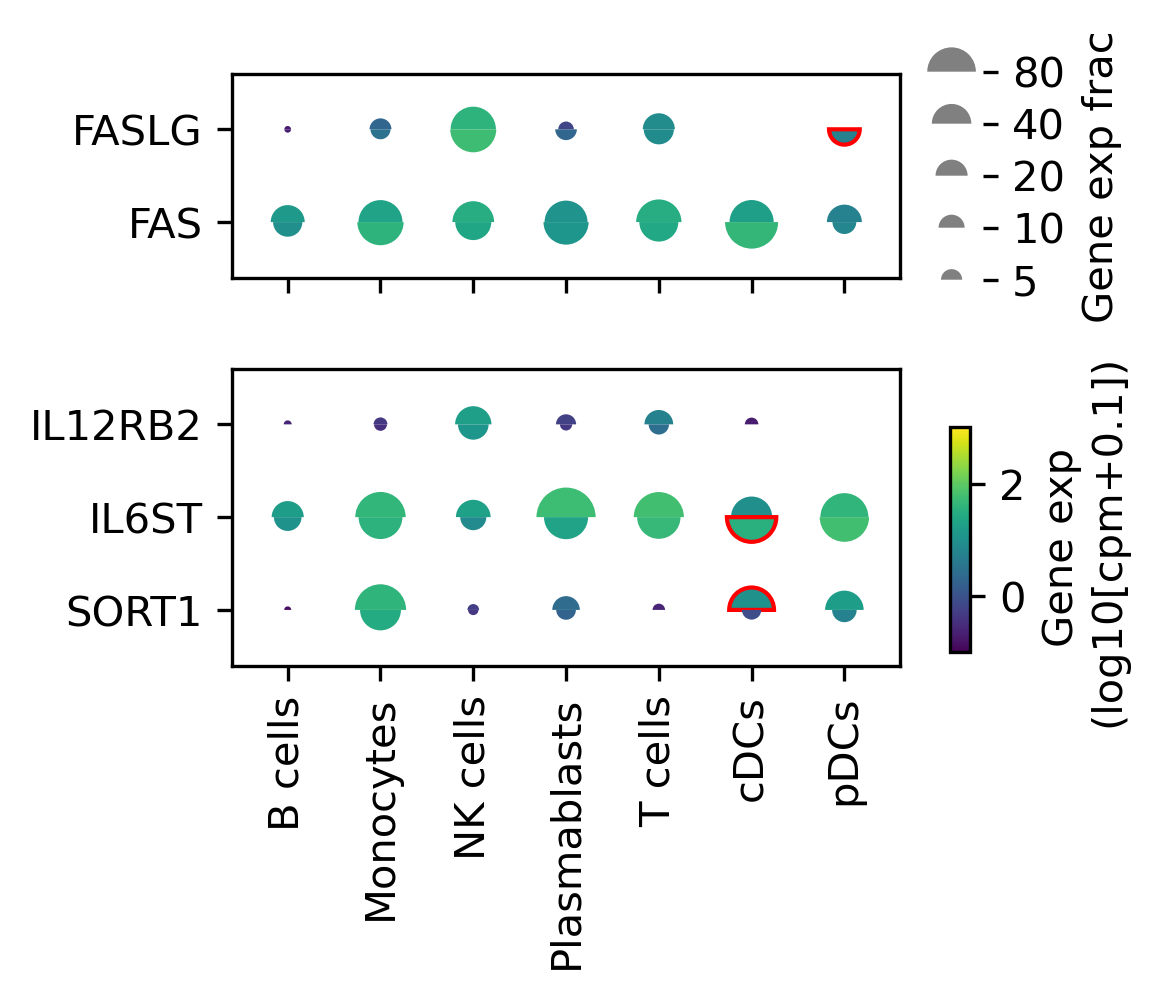

In [215]:
#genes = [
#    ['GAS6', 'TNF', 'EFNB1', 'AREG', 'ITGAM', 'ITGB2', 'CD1D', 'IL18', 'IFNG'],
#    ['AXL', 'VSIR', 'RIPK1', 'TNFRSF1B', 'EPHB1',  'ICAM1', 'LILRB2', 'IL18', 'IL18R1', 'IFNGR2'],
#]

#up_up_inters = [
#    ['GAS6', 'ICAM1', 'TNF', 'IL18'],
#    ['AXL', 'ITGAM', 'TNFRSF1B', 'IL18R1'] #ITGB2
#]

#down_down_inters = [
#    ['CLEC2D', 'LGALS9', 'TNFSF10', 'FASLG'],
#    ['KLRB1', 'HAVCR2', 'TNFRSF10C', 'TNFRSF1A']
#]

up_down_inters = [
['FAS', 'FASLG'],
['SORT1', 'IL6ST', 'IL12RB2']
]

mushrooms(up_down_inters)

In [19]:
def violin(gene, cell_type):
    print('Filter data for S_dnegue and dengue')
    adata_v = adata_children[adata_children.obs['Condition'].isin(['S_dengue', 'dengue'])]

    if cell_type == 'cDCs':
        adata_v = adata_v[~adata_v.obs['ID'].isin(['1_140_01', '5_193_01'])]

    print('Filter data for %s '%cell_type)
    adata_ct = adata_v[adata_v.obs['cell_type'] == cell_type]

    SD_IDs = list(adata_ct[adata_ct.obs['Condition'] == 'S_dengue'].obs['ID'].astype('category').cat.categories)
    D_IDs = list(adata_ct[adata_ct.obs['Condition'] == 'dengue'].obs['ID'].astype('category').cat.categories)

    print('Pick up 50 cells from each patient by random')
    df = pd.DataFrame([])
    for ID in SD_IDs + D_IDs:
        ID_info = adata_ct[adata_ct.obs['ID'] == ID][:, gene].X.toarray()[:, 0]
        if len(ID_info) < 50:
            df[ID] = np.random.choice(ID_info, size=50, replace=True)
        else:
            df[ID] = np.random.choice(ID_info, size=50, replace=False)
   
    print('Logarithm the picked data to log10')
    df = np.log10(df + 0.1)
    
    df[''] = [-100] * 50
    df = df[SD_IDs + [''] + D_IDs]
    
    fig, ax = plt.subplots(figsize=[1 + 0.3 * len(SD_IDs + [''] + D_IDs), 1], dpi=300)
    violin = ax.violinplot(df, showextrema=False)

    colors = sns.color_palette('pastel', len(SD_IDs + [''] + D_IDs))
    for i, patch in enumerate(violin['bodies']):
        patch.set_facecolor(colors[i])
        patch.set_edgecolor('black')
        patch.set_alpha(1)
    ax.set_xticks([0.5 + len(SD_IDs)/2, len(SD_IDs) + 1.5 + len(D_IDs)/2])
    ax.set_xticklabels(['Severe dengue', 'Dengue'])
    ax.set_ylabel('Gene exp\n(log10[cpm+0.1])')
    ax.set_ylim([-1.5, 4.5])
    ax.set_title(gene + ' in ' + cell_type.replace('_', ' '))
    return {'fig': fig, 'axs': ax}

Filter data for S_dnegue and dengue
Filter data for Monocytes 
Pick up 50 cells from each patient by random
Logarithm the picked data to log10


{'fig': <Figure size 1470x300 with 1 Axes>,
 'axs': <AxesSubplot:title={'center':'CCL2 in Monocytes'}, ylabel='Gene exp\n(log10[cpm+0.1])'>}

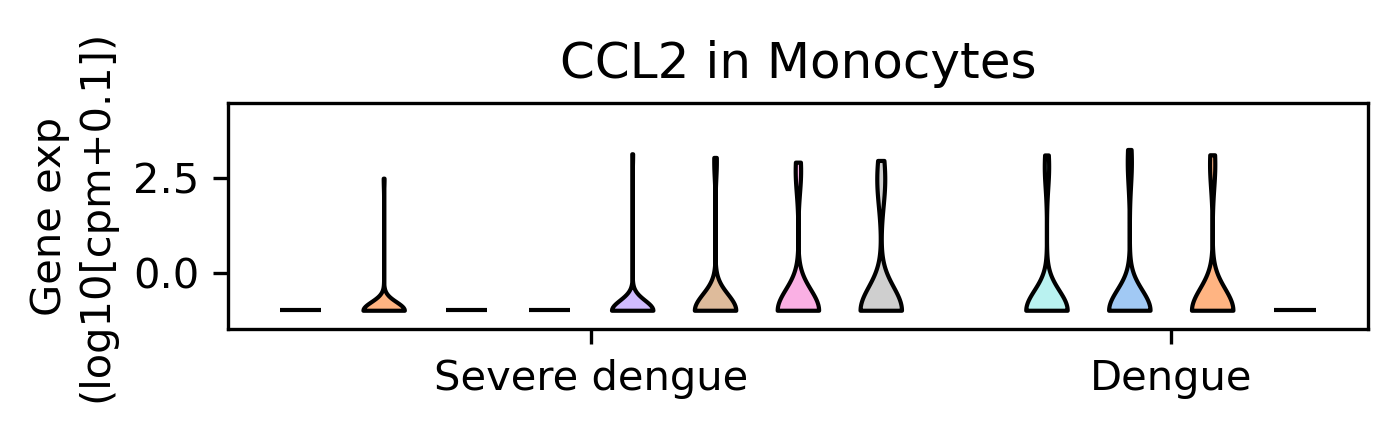

In [28]:
violin('CCL2', 'Monocytes')

In [35]:
SD_inters = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/final/specific_SD_inters.tsv', index_col=0)

In [36]:
SD_inters

,ga,gb,cta,ctb
0,FCER2,CR2,B_cells,B_cells
1,TNFRSF10A,TNFSF10,B_cells,B_cells
2,CD74,COPA,B_cells,B_cells
3,CD55,ADGRE5,B_cells,B_cells
4,LTA,TNFRSF1B,B_cells,B_cells
...,...,...,...,...
9,IL18,IL18,pDCs,pDCs
10,IL18R1,IL18,pDCs,pDCs
11,F11R,ITGB2,pDCs,pDCs
12,F11R,ITGAL,pDCs,pDCs
